In [1]:
# imports
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [2]:
# get stock data
def get_stock_data(stock_name, start=(1950,1,1), end=(2020,4,16), normalize=True):
    if start is None:
        start = datetime.datetime(2007, 1, 1)
    else:
        start = datetime.datetime(start[0],start[1],start[2])
    if end is None:
        end = datetime.date.today()
    else:
        end = datetime.datetime(end[0],end[1],end[2])
    
    

    # min max for every column
    min_open = 0
    min_close = 0
    min_high = 0
    min_low = 0
    min_volume = 0

    max_open = 0
    max_close = 0
    max_high = 0
    max_low = 0
    max_volume = 0


    try:
        # try scraping from online sources
        df = web.DataReader(stock_name, "yahoo", start, end)
        df.drop(['Close'], 1, inplace=True)
        df.to_csv('dataset.csv', sep='\t', encoding='utf-8')
        print("done saving to csv")
    except:
        # for some reason it can't connect, so use saved info
        headers = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
        df = csv_to_df('./dataset.csv', '\t', headers)

    if normalize:
        # uncomment to train it by normalizing test set independently
        '''
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
        df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
        '''

        # get min and max values from training values
        min_open = df['Open'].min()
        min_close = df['Adj Close'].min()
        min_high = df['High'].min()
        min_low = df['Low'].min()
        min_volume = df['Volume'].min()

        max_open = df['Open'].max()
        max_close = df['Adj Close'].max()
        max_high = df['High'].max()
        max_low = df['Low'].max()
        max_volume = df['Volume'].max()

        # normalise things
        df['Open'] = (df['Open'] - min_open)/(max_open - min_open)
        df['Adj Close'] = (df['Adj Close'] - min_close)/(max_close-min_close)
        df['High'] = (df['High'] - min_high)/(max_high - min_high)
        df['Low'] = (df['Low'] - min_low)/(max_low - min_low)
        df['Volume'] = (df['Volume'] -min_volume)/(max_volume - min_volume)
        df.to_csv('new_df_normalised.csv', sep='\t', encoding='utf-8')

    return df


In [3]:
# get that data
df = get_stock_data('^DJI', normalize=False)

# see the first 5 rows
df.head(5)

done saving to csv


,High,Low,Open,Volume,Adj Close
Date,,,,,
1985-01-29,1295.489990,1266.890015,1277.719971,13560000,1292.619995
1985-01-30,1305.099976,1278.930054,1297.369995,16820000,1287.880005
1985-01-31,1293.400024,1272.640015,1283.239990,14070000,1286.770020
1985-02-01,1286.109985,1269.770020,1276.939941,10980000,1277.719971
1985-02-04,1294.939941,1268.989990,1272.079956,11630000,1290.079956


In [4]:
# we will try predicting if price is going to increase or decrease
# as such we will first make those labels

# before that first find these values as individual arrays to manipulate
high = hi = df['High'].values
low = lo = df['Low'].values
open = op = df['Open'].values
volume = vo = df['Volume'].values
close = cl = df['Adj Close'].values

In [5]:
# create a sign function. This just returns the sign of the number you pass in:
def sgn(x):
    if x >= 0:
        return 1
    return 0 # let negatives be 0 for sandard 0/1 classification

In [6]:
# find labels
labels = [close[i+1]-close[i] for i in range(len(close)-1)]
labels = [sgn(i) for i in labels]

# so hi[i]...close[i] can be used to predict labels[i] (labels[i] predicts if next day is an increase or decrease)
# as such, the last day doesn't have a corresponding label
# we don't actually know what is going to happen! That's what we are trying to predict...
# so remove the last piece of information from all arrays
hi = hi[:-1]
lo = lo[:-1]
op = op[:-1]
vo = vo[:-1]
close = close[:-1]

In [35]:
# make the data matrix
data = np.array([hi,lo,op,vo,close])
# in this,ith column is the ith day's values (so row 2 for index i would be opening price for ith day)
# as such we need to transpose that matrix
data = data.T
data[:5]

array([[1.29548999e+03, 1.26689001e+03, 1.27771997e+03, 1.35600000e+07,
        1.29262000e+03],
       [1.30509998e+03, 1.27893005e+03, 1.29737000e+03, 1.68200000e+07,
        1.28788000e+03],
       [1.29340002e+03, 1.27264001e+03, 1.28323999e+03, 1.40700000e+07,
        1.28677002e+03],
       [1.28610999e+03, 1.26977002e+03, 1.27693994e+03, 1.09800000e+07,
        1.27771997e+03],
       [1.29493994e+03, 1.26898999e+03, 1.27207996e+03, 1.16300000e+07,
        1.29007996e+03]])

In [8]:
# visualise things... since there are so many data points, lets just take 2 different pointers for now, volume and closing price.
# first we make different labels for colors
colors = ['green' if i==1 else 'red' for i in labels ]

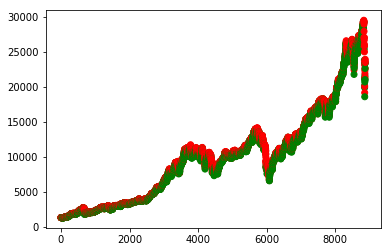

In [9]:
# now we have colors, plot them!
plt.scatter([i for i in range(len(close))], close, c=colors)

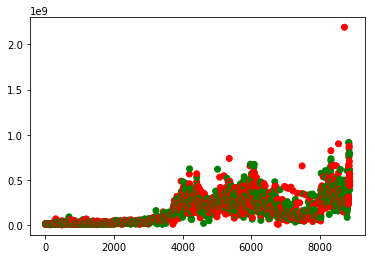

In [10]:
# same thing with volume
plt.scatter([i for i in range(len(close))], vo, c=colors)

In [11]:
# see data's shape
data.shape

(8875, 5)

In [12]:
# so we have 8802 samples, with 5 features each
# let's break them into 80% - 20% split
train = data[:int(0.8*len(data))]
test = data[int(0.8*len(data)):]
print(test.shape,train.shape)

# convert labels to numpy array to ease things
labels = np.array(labels).reshape(len(labels),1)

(1775, 5) (7100, 5)


In [36]:
# normalize them
train_min = np.min(train,axis=0)
test_min = np.min(test,axis=0)

train_max = np.max(train,axis=0)
test_max = np.max(test,axis=0)

train = (train-train_min)/(train_max-train_min)
test = (test-test_min)/(test_max-test_min)
train[:5]

array([[0.00332619, 0.00236948, 0.00255408, 0.01498825, 0.00379723],
       [0.00404806, 0.00327919, 0.00402976, 0.01941814, 0.00344131],
       [0.0031692 , 0.00280393, 0.00296862, 0.01568127, 0.00335796],
       [0.00262159, 0.00258708, 0.0024955 , 0.01148238, 0.0026784 ],
       [0.00328487, 0.00252815, 0.00213053, 0.01236564, 0.0036065 ]])

In [14]:
# define a sigmoid function. Why Sigmoid? It shows up in the posterior distros for a lot of things, especially
# bernoulli and all forms of gaussian...
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [15]:
# define likelihood fn (I use log likelihood, feel free to use whatever)
def likelihood(weights,data,labels):
    scores = np.dot(data, weights)
    likelihood = np.sum(labels*scores - np.log(1 + np.exp(scores)))
    return likelihood

In [26]:
# do the regression! yay!
# canonically, x is my data, y is their labels, intercept is if my predicted line should have an intercept
# or not (no intercept => go through origin)
# learning rate is how much you want to move by
# num_iter = how many iterations
def lr(x, y, intercept=True, learning_rate = 0.02, num_iter=100000):
    # if we have interceps, define that:
    if intercept:
        arr = np.ones(len(x)).reshape(len(x),1)
        x = np.hstack((arr,x))
    
    # define weights
    weights = np.zeros(len(x[0])).reshape(len(x[0]),1)
    
    # do it
    for step in range(num_iter+1):
        scores = np.dot(x, weights)
        predictions = sigmoid(scores)

        # Update weights with log likelihood gradient
        output_error_signal = y - predictions
        
        gradient = np.dot(x.T, output_error_signal)
        weights += learning_rate * gradient

        # Print log-likelihood every so often
        if step % 1000 == 0:
            print (likelihood(weights,x, y))
    
    return weights
        

In [37]:
train_labels = labels[:len(train)]
test_labels = labels[len(train):]
intercept = False
wts = lr(train,train_labels, intercept=intercept, learning_rate=0.0001)

-4918.585749458021
-4913.29972405839
-4913.219379060301
-4913.160035178852
-4913.101619437131
-4913.043662500805
-4912.986149755088
-4912.929077167268
-4912.8724409817005
-4912.8162374804615
-4912.760462977523
-4912.705113818376
-4912.6501863797475
-4912.59567706936
-4912.541582325664
-4912.487898617587
-4912.434622444278
-4912.381750334859
-4912.329278848174
-4912.277204572541
-4912.225524125511
-4912.174234153615
-4912.123331332132
-4912.072812364843
-4912.0226739838
-4911.972912949077
-4911.923526048549
-4911.87451009765
-4911.825861939149
-4911.777578442914
-4911.729656505691
-4911.682093050873
-4911.634885028282
-4911.588029413943
-4911.541523209861
-4911.49536344381
-4911.449547169112
-4911.404071464415
-4911.358933433497
-4911.314130205035
-4911.269658932406
-4911.225516793476
-4911.1817009903925
-4911.13820874938
-4911.095037320532
-4911.052183977622
-4911.009646017885
-4910.967420761831
-4910.925505553046
-4910.883897757994
-4910.842594765823
-4910.801593988177
-4910.760892858

In [38]:
# try getting accuracy
# first find predictions on training set. Rememmber to change things appropriately for intercept
train_acc = train
test_acc = test
if intercept:
    train_acc = np.hstack((np.ones(len(train)).reshape(len(train),1), train))
    test_acc = np.hstack((np.ones(len(test)).reshape(len(test),1), test))
print(wts)

[[ 1.79578253]
 [ 0.78156783]
 [ 3.04286232]
 [-0.31658282]
 [-5.34845303]]


In [39]:
# training accuracy
train_preds = np.round(sigmoid(np.dot(train_acc, wts)))

_ = [1 if train_labels[i] == train_preds[i] else 0 for i in range(len(train_preds))]
count = sum(_)
print(count/len(train_labels))

0.5335211267605634


In [40]:
# testt accuracy
test_preds = np.round(sigmoid(np.dot(test_acc, wts)))

_ = [1 if test_labels[i] == test_preds[i] else 0 for i in range(len(test_preds))]
count = sum(_)
print(count/len(test_labels))

0.5425352112676056
